In [1]:
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

100% (5000 of 5000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


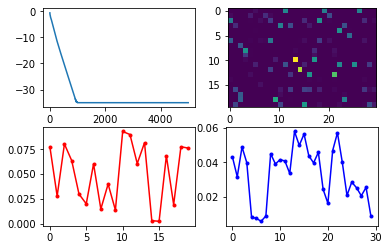

In [2]:
import sinkhorn
sinkhorn.test_points();

In [4]:
sys.path.append('./SCOT/src/')
import scot2 as sc
import evals as evals

Meyer's code.

In [5]:
def new_eval_func(P):
    frac = []
    n, m = np.shape(P)

    if n != m:
        print( 'n and m are not the same')
        return 'Error'

    for k in range(n):
        P_trans = P[k,:]
        ind_sorted = np.argsort(-P_trans)
        rank_1 = np.where(ind_sorted == k)[0][0]

        P_trans = P[:,k]
        ind_sorted = np.argsort(-P_trans)
        rank_2 = np.where(ind_sorted == k)[0][0]

        rank = rank_1 + rank_2
        frac.append(rank / (2 * (n-1)))

    return frac

In [6]:
path = './SCOT/'
#### SNARE-seq DATASET #####
X_trans = np.load(path + "data/scatac_feat.npy")
y_trans = np.load(path + "data/scrna_feat.npy")

#####################    Dataset SNAREseq    ########################
# X_trans = np.load(path + "data/scatac_feat.npy")
# y_trans = np.load(path + "data/scrna_feat.npy")

print("Dimensions of input datasets are: ", "X =", X_trans.shape, " y =", y_trans.shape)

Dimensions of input datasets are:  X = (1047, 19)  y = (1047, 10)


In [7]:
num_samples = np.shape(X_trans)[0]
## Normalize row by row the datasets
scot=sc.SCOT(X_trans, y_trans)
scot.normalize(norm='l2')
X = scot.X
Y = scot.y[0]
## Set the marginal to uniform distributions
a,b = np.ones(np.shape(X)[0])/np.shape(X)[0], np.ones(np.shape(Y)[0])/np.shape(Y)[0]
Y.shape

(1047, 10)

Compute the distance matrices based on shortest path distance

In [8]:
k = 35
scot.init_distances(k)
DX = scot.Cx[0]
DY = scot.Cy[0]

In [9]:
from sklearn.manifold import TSNE
X1 = TSNE(n_components=2).fit_transform(X)
Y1 = TSNE(n_components=2).fit_transform(Y)

(-48.555531120300294, 51.86303768157959, -48.46163158416748, 44.36043148040771)

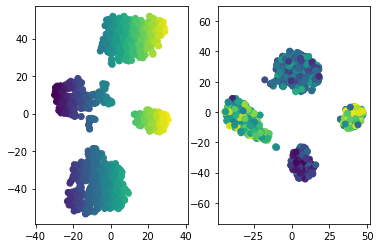

In [10]:
plt.subplot(1,2,1)
plt.scatter(X1[:,0], X1[:,1], c=X1[:,0])
plt.axis('equal')
plt.subplot(1,2,2)
plt.scatter(Y1[:,0], Y1[:,1], c=X1[:,0]) 
plt.axis('equal')

# Baseline (OT lower bound)

In [11]:
def distmat_square(X, Y):
    """ Compute pairwise distance matrix.
        X is of size (n,d)
        Y is of size (m,d)
        output is of size (n,m)
    """
    X_sq = (X ** 2).sum(axis=-1)
    Y_sq = (Y ** 2).sum(axis=-1)
    cross_term = X.dot(Y.T)
    return X_sq[:, None] + Y_sq[None, :] - 2 * cross_term

Commpute a cost matrix using W2 1D distance of the rows of the distance matrices.

In [12]:
n = DX.shape[0]
m = DY.shape[0]
DXs = np.sort(DX, axis=1)
DYs = np.sort(DY, axis=1)
# cost
C = distmat_square(DXs,DYs)
C = C/np.std(C.flatten())

100% (300 of 300) |######################| Elapsed Time: 0:00:19 Time:  0:00:19


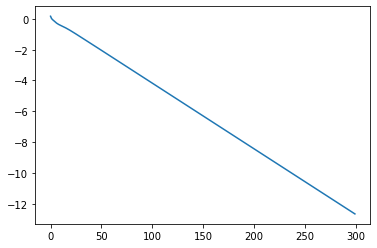

In [13]:
import sinkhorn
epsilon=(.2)**2
P,f,g,Err = sinkhorn.solve(a,b,C,epsilon,niter=300,verb=True)
plt.plot(np.log10(Err))

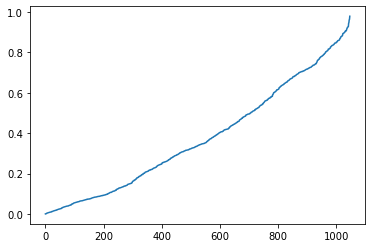

In [14]:
fracs = new_eval_func(P)
plt.plot(np.arange(len(fracs)), np.sort(fracs))

In [ ]:
if 0:
    P_Sin = Couplings_Sin[ind_gamma+2,:,:]
    y_aligned = proj_bary_Y_to_X(P_Sin,X,Y,a,b)
    fracs = evals.calc_domainAveraged_FOSCTTM(X, y_aligned)
    #fracs = new_eval_func(P_Sin)
    plot(np.arange(len(fracs)), np.sort(fracs))

# UGW - TODO

In [16]:
import sys
sys.path.append("../")
import torch

In [ ]:
import unbalancedgw
from solver.vanilla_ugw_solver import VanillaSinkhornSolver

In [ ]:
epsilon = 0.01

pi0 = torch.rand((n,n))
pi0 = pi0/torch.sum(pi0)

solv = VanillaSinkhornSolver(nits_plan=30, nits_sinkhorn=100, gradient=False, tol_plan=1e-5, tol_sinkhorn=1e-5,
                             eps=epsilon, rho=float("Inf"))

pi, gamma = solv.alternate_sinkhorn(a, CX, b, CY, init=pi0)
cost = solv.ugw_cost(pi, gamma, a, CX, b, CY)